In [1]:
import pandas as pd
import numpy as np
import acessos as ac
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
query = '''

select * from customer_sandbox_zone.dados_estudo_mgm_flavia


'''

In [3]:
df = ac.df_athena('flavia-costa', query)

In [4]:
len(df)

1000000

In [5]:
df.columns

Index(['cpf', 'tempo_aprovacao', 'tempo_relacionamento', 'ganho_limite',
       'ds_risk_type', 'gender', 'nr_declared_income', 'ds_region',
       'flag_autonomo', 'max_limite', 'max_qtd_if', 'avg_utilizado_interno',
       'sum_utilizado_interno', 'avg_utilizado_mercado',
       'sum_utilizado_mercado', 'nr_chaves_importantes',
       'nr_antecipacao_fatura', 'nr_bolso_ativo', 'nr_trans_mov_conta',
       'nr_purchases_virtual', 'avg_vl_total_spending', 'nr_purchases_online',
       'nr_acessos', 'pc_acessos_lojawill', 'flag_mgm', 'flag_indicado',
       'dias_atraso', 'ordem', 'flag_limite_insuficiente', 'share_of_wallet'],
      dtype='object')

In [5]:
#variáveis para recodificar como zero
df['share_of_wallet'] = df['share_of_wallet'].fillna(0.0)
df['ganho_limite'] = df['ganho_limite'].fillna(0.0)

df['nr_purchases_online'] = df['nr_purchases_online'].fillna(0.0)
df['nr_acessos'] = df['nr_acessos'].fillna(0.0)
df['pc_acessos_lojawill'] = df['pc_acessos_lojawill'].fillna(0.0)
df['nr_chaves_importantes'] = df['nr_chaves_importantes'].fillna(0.0)

In [6]:
for column in df.columns:
  if df[column].dtype == 'object' or df[column].dtype == 'string':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object' and df[column].dtype != 'string':
    df[column].fillna(df[column].median(), inplace = True)

In [8]:
df['flag_mgm'].value_counts()

1    500000
0    500000
Name: flag_mgm, dtype: int64

In [9]:
df['flag_mgm'].value_counts(normalize = True)

1    0.5
0    0.5
Name: flag_mgm, dtype: float64

In [7]:
id_columns = ['cpf', 'ordem']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('object').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['object']).columns

In [8]:
predictors = df.drop(id_columns, axis = 1).select_dtypes(exclude=['object']).drop(['flag_mgm'], axis = 1).columns

In [9]:
total_features = df.drop(id_columns, axis = 1).columns

### Correlações

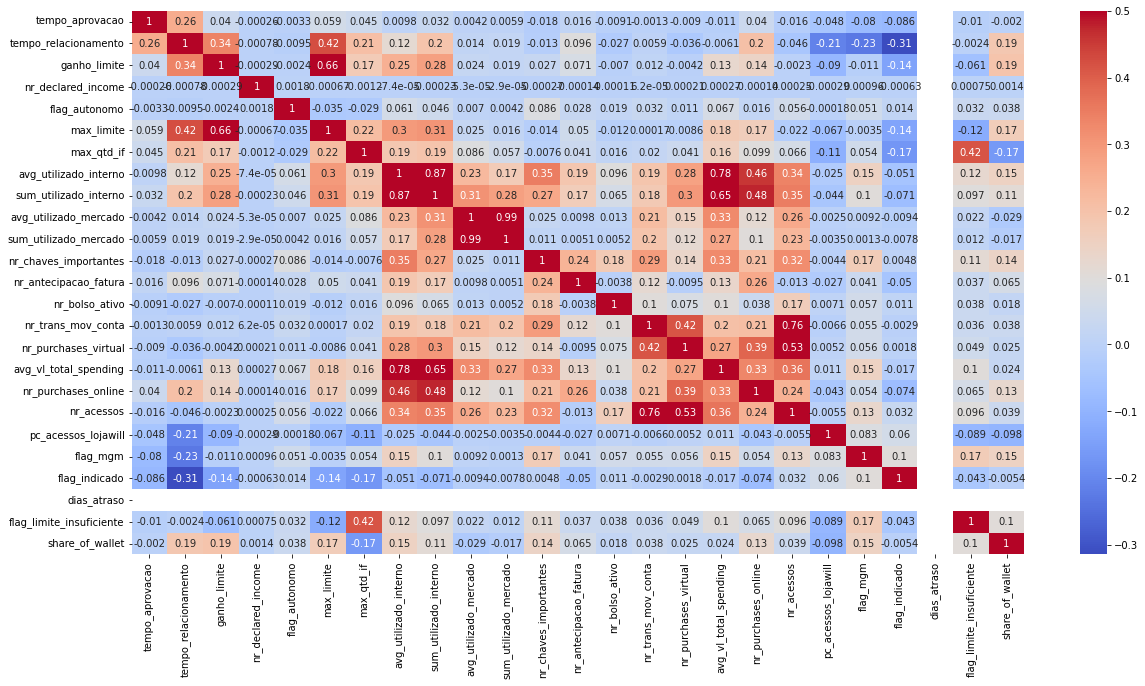

In [12]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(df.drop(id_columns, axis=1).corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [10]:
df["tempo_relacionamento_meses"] = df.tempo_relacionamento / 30

In [60]:
features_cluster = ['flag_mgm', 'tempo_relacionamento_meses', 'max_qtd_if', 'share_of_wallet']

base_cluster = df[features_cluster].sample(50000)

In [15]:
len(base_cluster)

50000

In [61]:
base_cluster.flag_mgm.value_counts()

0    25163
1    24837
Name: flag_mgm, dtype: int64

In [62]:
base_cluster.head(3)

,flag_mgm,tempo_relacionamento_meses,max_qtd_if,share_of_wallet
710109,1,12.266667,8,0.084525
970123,0,21.800000,4,0.198378
596617,0,2.633333,4,0.137060


In [18]:
base_cluster.dtypes

flag_mgm                  int64
tempo_relacionamento    float64
share_of_wallet         float64
ganho_limite            float64
dtype: object

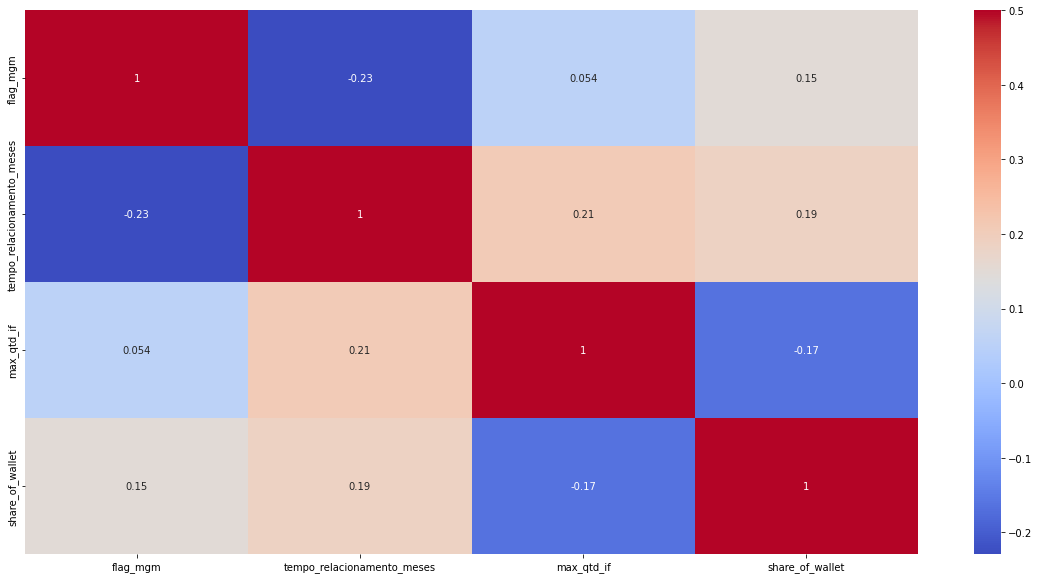

In [63]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(df[features_cluster].corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [20]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans

In [64]:
#NORMALIZAÇÃO
scaler = RobustScaler()
scaler_model = scaler.fit(base_cluster)
data_input_scaled = scaler_model.transform(base_cluster)

/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/flavia.costa/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


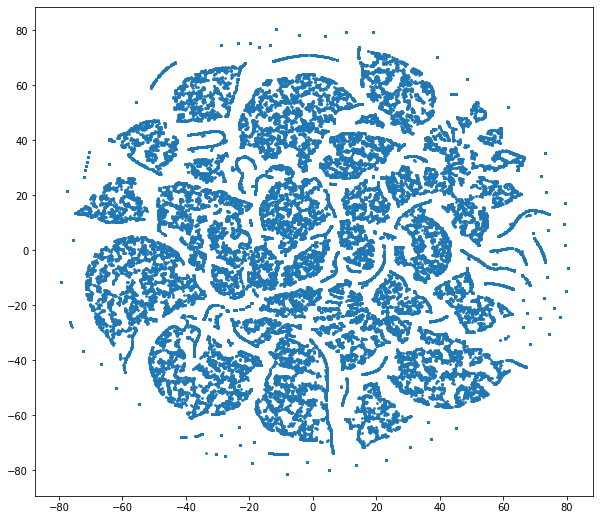

In [65]:
tsne = TSNE(n_components=2, random_state=0)
base_cluster_tsne = tsne.fit_transform(data_input_scaled)

plt.figure(figsize=(10,9))
plt.scatter(base_cluster_tsne[:, 0], base_cluster_tsne[:, 1], s=3, cmap='Spectral')
plt.show()

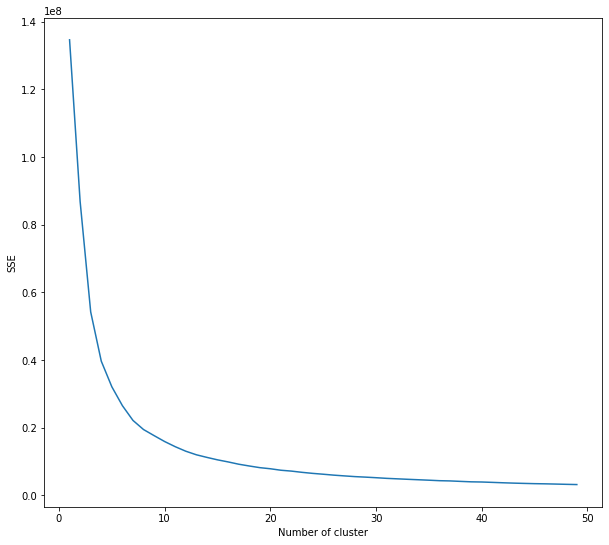

In [66]:
#AVALIANDO MELHOR NR DE CLUSTERS
sse = {}
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(base_cluster_tsne)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10,9))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [67]:
#DEFININDO NR DE CLUSTERS
k = 45

#ALGORITMO
kmeans = KMeans(n_clusters = k, random_state=0).fit(base_cluster_tsne)


cluster = kmeans.predict(base_cluster_tsne)
base_cluster['cluster'] = cluster

print("---------------VOLUMETRIA ------------------")
print(base_cluster['cluster'].value_counts())


---------------VOLUMETRIA ------------------
5     1499
7     1391
35    1367
25    1358
32    1355
23    1293
38    1280
9     1279
10    1277
19    1257
2     1252
40    1250
28    1235
3     1233
21    1223
0     1215
12    1213
14    1212
20    1196
1     1183
27    1162
30    1155
31    1152
15    1138
4     1128
44    1086
42    1082
11    1066
43    1064
39    1063
36    1061
33    1059
18    1033
24    1023
34    1021
17    1004
29     932
41     919
26     891
8      872
16     849
6      791
13     752
37     586
22     543
Name: cluster, dtype: int64


In [68]:
print("---------------VOLUMETRIA ------------------")
print(base_cluster['cluster'].value_counts(normalize = True))

---------------VOLUMETRIA ------------------
5     0.02998
7     0.02782
35    0.02734
25    0.02716
32    0.02710
23    0.02586
38    0.02560
9     0.02558
10    0.02554
19    0.02514
2     0.02504
40    0.02500
28    0.02470
3     0.02466
21    0.02446
0     0.02430
12    0.02426
14    0.02424
20    0.02392
1     0.02366
27    0.02324
30    0.02310
31    0.02304
15    0.02276
4     0.02256
44    0.02172
42    0.02164
11    0.02132
43    0.02128
39    0.02126
36    0.02122
33    0.02118
18    0.02066
24    0.02046
34    0.02042
17    0.02008
29    0.01864
41    0.01838
26    0.01782
8     0.01744
16    0.01698
6     0.01582
13    0.01504
37    0.01172
22    0.01086
Name: cluster, dtype: float64


In [69]:
def highlight_max(s):
    is_max = s > s.quantile(0.50)
    return ['background-color: yellow' if v else '' for v in is_max]

print("---------------MEDIAS POR CLUSTER ------------")
cl_col = ['cluster']
totalfeat = features_cluster + cl_col
base_cluster[totalfeat].groupby('cluster').mean().style.apply(highlight_max)

---------------MEDIAS POR CLUSTER ------------


,flag_mgm,tempo_relacionamento_meses,max_qtd_if,share_of_wallet
cluster,,,,
0,0.840329,7.051440,0.792593,0.422547
1,0.971260,11.225810,6.628064,0.169784
2,0.694888,41.373136,4.926518,0.321074
3,0.000000,58.912003,5.436334,0.413003
4,0.254433,18.871188,2.492908,0.244835
5,0.951301,10.383278,5.707805,0.221542
6,0.182048,7.239486,1.795196,0.007659
7,0.068296,55.821735,7.817398,0.248587
8,0.884174,6.910168,2.652523,0.178322


/home/flavia.costa/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


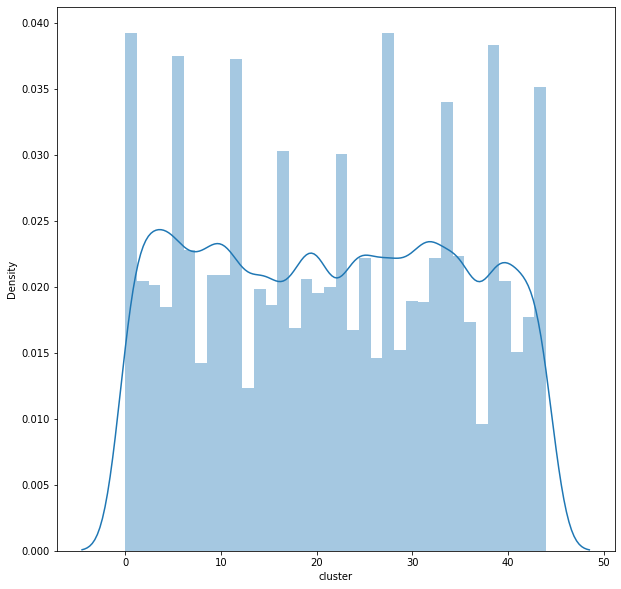

In [70]:
plt.figure(figsize=(10,10))
sns.distplot(base_cluster['cluster'])
plt.show()

In [71]:
base_cluster

,flag_mgm,tempo_relacionamento_meses,max_qtd_if,share_of_wallet,cluster
710109,1,12.266667,8,0.084525,1
970123,0,21.800000,4,0.198378,20
596617,0,2.633333,4,0.137060,10
441384,0,0.800000,0,0.000000,0
386059,1,5.733333,1,0.504287,0
...,...,...,...,...,...
139304,1,50.633333,4,0.795555,25
322357,0,47.633333,4,0.000000,25
306228,1,8.266667,3,0.438936,41
589445,0,3.566667,7,0.141158,18


In [72]:
features_cluster

['flag_mgm', 'tempo_relacionamento_meses', 'max_qtd_if', 'share_of_wallet']

In [73]:
agg = base_cluster[totalfeat].groupby('cluster').mean()
agg = agg.reset_index()

for i in features_cluster:
    agg[i] = (agg[i] - agg[i].min()) / (agg[i].max() - agg[i].min())

In [74]:
base_cluster.flag_mgm.mean()

0.49674

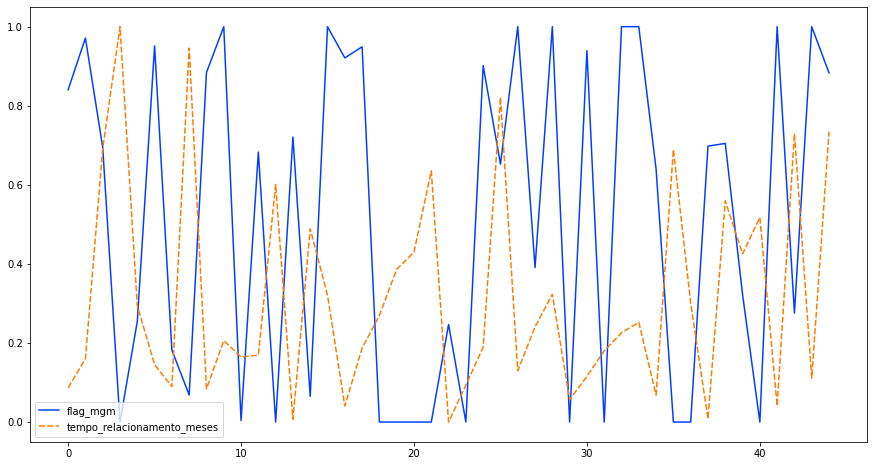

In [77]:
plt.figure(figsize=(15,8))
sns.lineplot(data = agg.drop('cluster', axis = 1)[['flag_mgm', 'tempo_relacionamento_meses']], palette = 'bright')
plt.show()

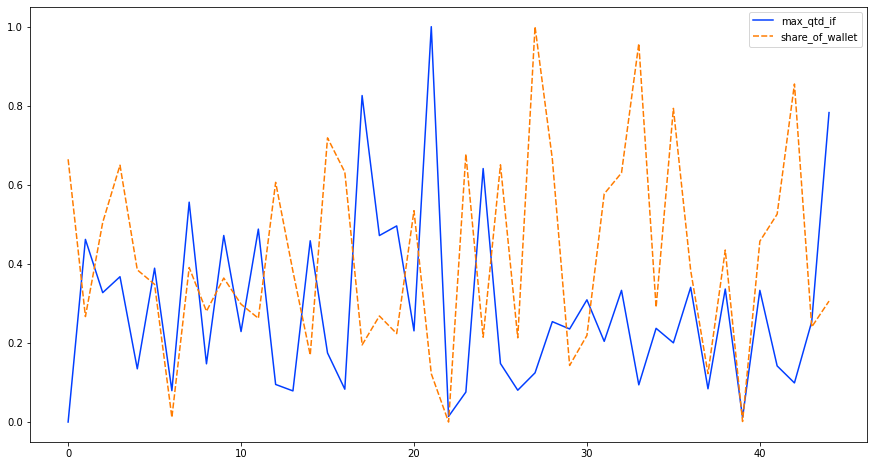

In [78]:
plt.figure(figsize=(15,8))
sns.lineplot(data = agg.drop('cluster', axis = 1)[['max_qtd_if', 'share_of_wallet']], palette = 'bright')
plt.show()

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(base_cluster[features_cluster]
                                                    , base_cluster['cluster']
                                                    , random_state=42, test_size=0.20)
arvores = [50, 100, 300, 400]
accuracy_array = []

for i in arvores:
  rf = RandomForestClassifier(n_estimators=i)
  rf.fit(x_train, y_train)
  y_predicted_rf = rf.predict(x_test)
  accuracy_rf = accuracy_score(y_test, y_predicted_rf).round(4)
  accuracy_array.append(accuracy_rf)
  print(i)
rf_estimators = pd.DataFrame(list(zip(arvores, accuracy_array)), columns =['arvores', 'acuracia'])
print("---------------ACURACCY CLASSIFICATION ------------")
rf_estimators['acuracia'].max()



50
100
300
400
---------------ACURACCY CLASSIFICATION ------------


0.9907

---------------IMPORTANCIA DAS FEATURES - O QUE MAIS PESOU NA CONSTRUÇÃO DOS GRUPOS? ------------


<AxesSubplot:>

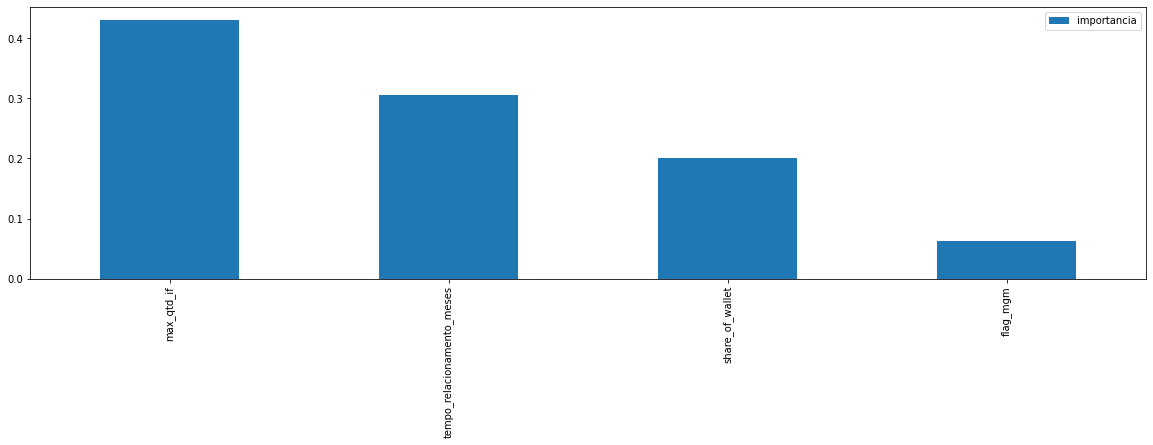

In [80]:
print("---------------IMPORTANCIA DAS FEATURES - O QUE MAIS PESOU NA CONSTRUÇÃO DOS GRUPOS? ------------")
best_rf = RandomForestClassifier(n_estimators= rf_estimators['arvores'][rf_estimators['acuracia'].idxmax()])
best_rf.fit(x_train, y_train)
importance_df = pd.DataFrame(best_rf.feature_importances_, columns = ['importancia'], index = features_cluster)
importance_df.sort_values(by='importancia', ascending=False).head(15).plot.bar(figsize=(20,5))


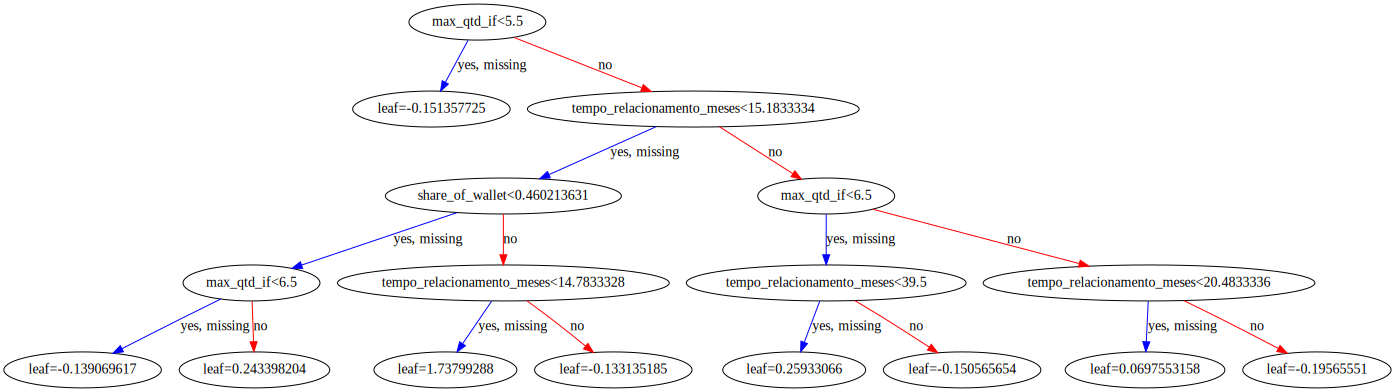

In [82]:
#utilizando o xgboost
import xgboost as xgb
clf = xgb.XGBClassifier(objective="multi:softprob", max_depth=4, random_state=42) #early_stopping_rounds=2
clf.fit(x_train, y_train)
#arvore de decisão
import graphviz
xgb.to_graphviz(clf, num_trees=clf.best_iteration)

In [84]:
y_predicted = clf.predict(x_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       238
           2       0.98      0.99      0.98       300
           3       0.99      0.98      0.99       242
           4       0.99      0.99      0.99       211
           5       0.99      1.00      0.99       312
           6       0.99      0.99      0.99       153
           7       0.99      0.99      0.99       285
           8       0.99      0.99      0.99       166
           9       0.99      0.98      0.99       256
          10       0.99      0.97      0.98       266
          11       0.98      0.99      0.98       203
          12       0.98      0.96      0.97       251
          13       0.99      0.99      0.99       144
          14       0.98      0.98      0.98       241
          15       0.99      0.99      0.99       238
          16       0.99      1.00      1.00       157
          17       0.99    

In [87]:
df['gr_relacionamento'] = np.where(df.tempo_relacionamento_meses < 6, "A", 
                          np.where(df.tempo_relacionamento_meses < 20, "B",          
                          np.where(df.tempo_relacionamento_meses < 40, "C",          
                                   "D")))

df['gr_qtd_if'] = np.where(df.max_qtd_if < 5, "A", 
                       np.where(df.max_qtd_if < 6, "B", "C"))

df['gr_sow'] = np.where(df.share_of_wallet < 0.46, "A", "B")

df['cluster_regra'] = df['gr_relacionamento'] + df['gr_qtd_if'] + df['gr_sow']

df['cluster_regra'].value_counts()

AAA    186814
BCA    101339
BAA     99645
CCA     71657
DCA     65706
BAB     58784
DAA     52193
CAA     48350
DAB     48170
ACA     47050
CAB     45762
AAB     40569
BBA     33434
ABA     21988
CBA     18117
DBA     15903
DCB     12332
DBB      9087
CBB      5814
CCB      5633
BBB      5014
BCB      3951
ABB      1625
ACB      1063
Name: cluster_regra, dtype: int64

In [88]:
pd.crosstab(df['cluster_regra'], df['flag_mgm'], normalize='index').style.apply(highlight_max)

flag_mgm,0,1
cluster_regra,,
AAA,0.499652,0.500348
AAB,0.354606,0.645394
ABA,0.393351,0.606649
ABB,0.316308,0.683692
ACA,0.377194,0.622806
ACB,0.300094,0.699906
BAA,0.425430,0.574570
BAB,0.309608,0.690392
BBA,0.353861,0.646139


In [101]:
df['cluster_regra2'] = df['gr_relacionamento'] + df['gr_qtd_if']

df['cluster_regra2'].value_counts()

AA    227383
BA    158429
BC    105290
DA    100363
CA     94112
DC     78038
CC     77290
AC     48113
BB     38448
DB     24990
CB     23931
AB     23613
Name: cluster_regra2, dtype: int64

In [102]:
pd.crosstab(df['cluster_regra2'], df['flag_mgm'], normalize='index').style.apply(highlight_max)

flag_mgm,0,1
cluster_regra2,,
AA,0.473773,0.526227
AB,0.388049,0.611951
AC,0.375491,0.624509
BA,0.382455,0.617545
BB,0.337625,0.662375
BC,0.327970,0.672030
CA,0.610857,0.389143
CB,0.549329,0.450671
CC,0.548130,0.451870


In [119]:
df['cluster_regra3'] = df['gr_relacionamento'] + df['gr_sow']

In [121]:
df['cluster_regra3'].value_counts(normalize=True)

AA    0.255852
BA    0.234418
CA    0.138124
DA    0.133802
DB    0.069589
BB    0.067749
CB    0.057209
AB    0.043257
Name: cluster_regra3, dtype: float64

In [120]:
pd.crosstab(df['cluster_regra3'], df['flag_mgm'], normalize='index').style.apply(highlight_max)

flag_mgm,0,1
cluster_regra3,,
AA,0.467997,0.532003
AB,0.351827,0.648173
BA,0.375031,0.624969
BB,0.298027,0.701973
CA,0.601612,0.398388
CB,0.522697,0.477303
DA,0.765407,0.234593
DB,0.596718,0.403282


In [125]:
df['target_regra3'] = np.where(np.isin(df['cluster_regra3'], ['AA', 'AB','BA','BB'] ), 1, 0)

In [126]:
print(classification_report(df['flag_mgm'], df['target_regra3']))

              precision    recall  f1-score   support

           0       0.64      0.51      0.57    500000
           1       0.60      0.72      0.65    500000

    accuracy                           0.62   1000000
   macro avg       0.62      0.62      0.61   1000000
weighted avg       0.62      0.62      0.61   1000000



### Teste Modelo

In [91]:
cat_columns

Index(['ds_risk_type', 'gender', 'ds_region'], dtype='object')

In [97]:
df['flag_mgm'].value_counts()

1    500000
0    500000
Name: flag_mgm, dtype: int64

In [109]:
num_columns

Index(['tempo_aprovacao', 'tempo_relacionamento', 'ganho_limite',
       'nr_declared_income', 'flag_autonomo', 'max_limite', 'max_qtd_if',
       'avg_utilizado_interno', 'sum_utilizado_interno',
       'avg_utilizado_mercado', 'sum_utilizado_mercado',
       'nr_chaves_importantes', 'nr_antecipacao_fatura', 'nr_bolso_ativo',
       'nr_trans_mov_conta', 'nr_purchases_virtual', 'avg_vl_total_spending',
       'nr_purchases_online', 'nr_acessos', 'pc_acessos_lojawill', 'flag_mgm',
       'flag_indicado', 'dias_atraso', 'flag_limite_insuficiente',
       'share_of_wallet'],
      dtype='object')

In [112]:
x_train, x_test, y_train, y_test = train_test_split(df[predictors]
                                                    , df['flag_mgm']
                                                    , random_state=42, test_size=0.20)

In [113]:
y_train.value_counts()

0    400124
1    399876
Name: flag_mgm, dtype: int64

In [114]:
#utilizando o xgboost
import xgboost as xgb
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42) #early_stopping_rounds=2
clf.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

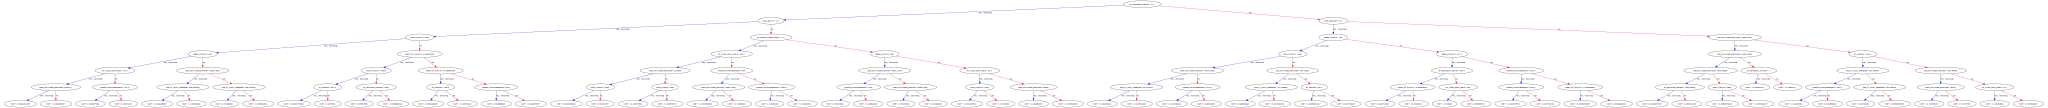

In [115]:
#arvore de decisão
import graphviz
xgb.to_graphviz(clf, num_trees=clf.best_iteration)

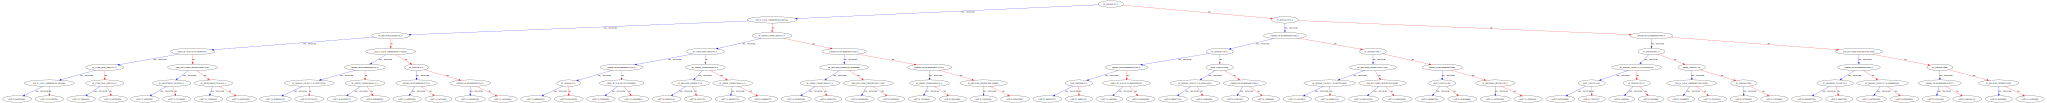

In [116]:
xgb.to_graphviz(clf, num_trees=4)

In [117]:
y_predicted = clf.predict(x_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72     99876
           1       0.72      0.73      0.73    100124

    accuracy                           0.72    200000
   macro avg       0.72      0.72      0.72    200000
weighted avg       0.72      0.72      0.72    200000



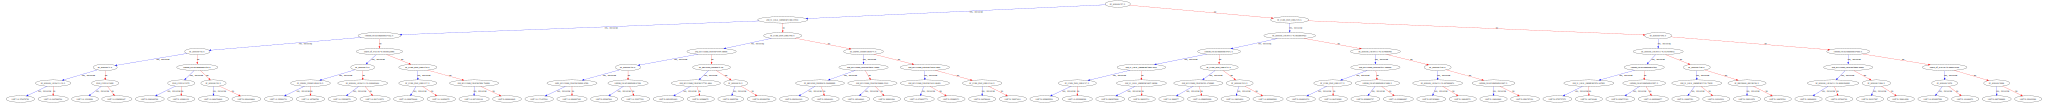

In [118]:
xgb.to_graphviz(clf, num_trees=3)

In [13]:
#nr_acessos

def fx_acessos(x):
    if x == 0:
        return 'A'
    elif x <= 2:
        return 'B'
    elif x <= 4:
        return 'C'
    elif x <= 10:
        return 'D'
    elif x <= 25:
        return 'E'
    elif x <= 60:
        return 'F'
    elif x <= 130:
        return 'G'
    elif x <= 210:
        return 'H'
    elif x <= 350:
        return 'I'
    elif x <= 1500:
        return 'J'
    else:
        return 'K'


df['fx_nr_acessos'] = df.nr_acessos.apply(fx_acessos)

df['fx_nr_acessos'].value_counts()

A    317375
G    143354
F    116965
H     97922
J     83298
E     78177
I     72814
D     42210
B     18306
C     17636
K     11943
Name: fx_nr_acessos, dtype: int64

In [14]:
def fx_tmp(x):
    if x <= 50:
        return 'A'
    elif x <= 150:
        return 'B'
    elif x <= 350:
        return 'C'
    elif x <= 700:
        return 'D'
    elif x <= 1000:
        return 'E'
    elif x <= 1100:
        return 'F'
    else:
        return 'G'

df['fx_tempo_relacionamento'] = df.tempo_relacionamento.apply(fx_tmp)

df['fx_tempo_relacionamento'].value_counts()

D    219226
G    217640
B    176665
C    171779
E     91443
A     88747
F     34500
Name: fx_tempo_relacionamento, dtype: int64

In [15]:

def fx_spd(x):
    if x <= 980:
        return 'A'
    elif x <= 1500:
        return 'B'
    elif x <= 1700:
        return 'C'
    elif x <= 1800:
        return 'D'
    elif x <= 3500:
        return 'E'
    elif x <= 4800:
        return 'F'
    else:
        return 'G'

df['fx_spending'] = df.avg_vl_total_spending.apply(fx_spd)

df['fx_spending'].value_counts()

A    619756
B    136349
E    115880
G     50363
C     32313
F     31257
D     14082
Name: fx_spending, dtype: int64

In [16]:
def fx_mov_conta(x):
    if x <= 20:
        return 'A'
    elif x <= 60:
        return 'B'
    elif x <= 115:
        return 'C'
    else:
        return 'D'

df['fx_mov_conta'] = df.nr_trans_mov_conta.apply(fx_mov_conta)

df['fx_mov_conta'].value_counts()

A    676590
B    154830
D    102710
C     65870
Name: fx_mov_conta, dtype: int64

In [18]:

def fx_interno(x):
    if x <= 95:
        return 'A'
    elif x <= 520:
        return 'B'
    elif x <= 960:
        return 'C'
    elif x <= 1615:
        return 'D'
    elif x <= 3800:
        return 'E'
    elif x <= 5900:
        return 'F'
    elif x <= 9800:
        return 'G'
    elif x <= 27000:
        return 'H'
    else:
        return 'I'

df['fx_utiliz_interno'] = df.avg_utilizado_interno.apply(fx_interno)

df['fx_utiliz_interno'].value_counts()


D    227765
E    209361
A    137097
C    129936
B    116600
F     70849
G     53664
H     44654
I     10074
Name: fx_utiliz_interno, dtype: int64

In [23]:

def fx_loja(x):
    if x <= 0.003:
        return 'A'
    elif x <= 0.01:
        return 'B'
    elif x <= 0.02:
        return 'C'
    elif x <= 0.07:
        return 'D'
    elif x <= 0.2:
        return 'E'
    elif x <= 0.5:
        return 'F'
    else:
        return 'G'

df['fx_loja_will'] = df.pc_acessos_lojawill.apply(fx_loja)

df['fx_loja_will'].value_counts()

A    748662
D     87957
B     66023
C     58053
E     32550
F      6061
G       694
Name: fx_loja_will, dtype: int64

In [24]:
def fx_limite(x):
    if x <= 1000:
        return 'A'
    elif x <= 1600:
        return 'B'
    elif x <= 1900:
        return 'C'
    else:
        return 'D'

df['fx_limite'] = df.max_limite.apply(fx_limite)

df['fx_limite'].value_counts()

D    448359
A    305803
B    186396
C     59442
Name: fx_limite, dtype: int64

In [26]:

def fx_sow(x):
    if x <= 0.005:
        return 'A'
    elif x <= 0.10:
        return 'B'
    elif x <= 0.30:
        return 'C'
    else:
        return 'D'

df['fx_sow'] = df.share_of_wallet.apply(fx_sow)

df['fx_sow'].value_counts()

D    436629
C    250757
A    210412
B    102202
Name: fx_sow, dtype: int64

In [27]:
def fx_online(x):
    if x <= 20:
        return 'A'
    elif x <= 30:
        return 'B'
    else:
        return 'C'

df['fx_online'] = df.nr_purchases_online.apply(fx_online)

df['fx_online'].value_counts()

A    667460
C    270919
B     61621
Name: fx_online, dtype: int64

In [29]:
def fx_chaves_pix(x):
    if x <= 0:
        return 'A'
    elif x <= 8:
        return 'B'
    else:
        return 'C'

df['fx_chaves_pix'] = df.nr_chaves_importantes.apply(fx_chaves_pix)

df['fx_chaves_pix'].value_counts()

A    609774
B    375942
C     14284
Name: fx_chaves_pix, dtype: int64

In [30]:
df['cluster_arvore'] = df['fx_tempo_relacionamento'] + df['fx_spending'] + df['fx_mov_conta'] + df['fx_utiliz_interno'] + df['fx_loja_will'] + df['fx_limite'] + df['fx_sow'] + df['fx_online'] + df['fx_chaves_pix']  

In [31]:
df['cluster_arvore'].value_counts()

GAAAAAAAA    17930
AAADAAAAA    15185
AAADADAAA    11589
GAAAADAAA     7794
AAADABAAA     7680
             ...  
CEDGCDBAA        1
EADDABABB        1
AEAHADDAA        1
DCBFADBBA        1
GBABABCBA        1
Name: cluster_arvore, Length: 72939, dtype: int64

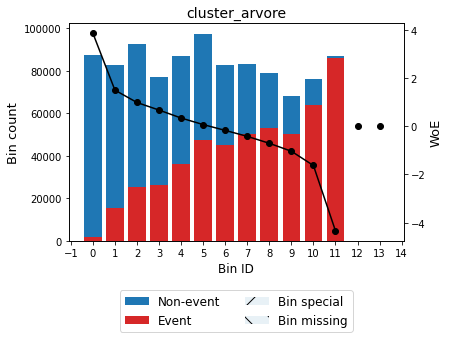

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.61284477
    IV (Jeffrey)             1.95286069
    JS (Jensen-Shannon)      0.17289625
    Hellinger                0.19887889
    Triangular               0.57779959
    KS                       0.44045200
    HHI                      0.08400393
    HHI (normalized)         0.01354269
    Cramer's V               0.53749400
    Quality score            0.00004137

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
        0      1 12558.169900  0.000000e+00  0.000000e+00       1.0
        1      2  1962.706665  0.000000e+00  0.000000e+00       1.0
        2      3   880.171803 2.005792e-193  0.000000e+00       1.0
        3      4  1035.869712 2.868265e-227  0.000000e+00       1.0
        4      5   834.112304 2.068346

In [37]:
#optimal binning
from optbinning import OptimalBinning
from optbinning import BinningProcess

binning_process = BinningProcess(variable_names=list(['cluster_arvore']))
binning_process.fit(df[['cluster_arvore']], df['flag_mgm'])

optb = binning_process.get_binned_variable(name='cluster_arvore')
optb.binning_table.plot()
optb.binning_table.analysis()

In [50]:
binning_process.summary()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,cluster_arvore,categorical,OPTIMAL,True,12,1.952861,0.172896,0.612845,0.000041


In [51]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[BBACADDCA, CABDDDAAA, EDAEDBCCA, BBCECDCBA, E...",87477,0.087477,85659,1818,0.020783,3.852637,0.646018,0.051793
1,"[FAABAADCA, EAAAABAAB, GEADABAAA, GAAHADDCA, G...",82570,0.082570,67386,15184,0.183892,1.490195,0.155582,0.017827
2,"[GAADADCCB, EAADABBCA, EAACADCCA, FAADADBAA, E...",92583,0.092583,67281,25302,0.273290,0.977994,0.082110,0.009873
3,"[EAADADCAA, FAAEADDCB, DAAAADBAA, DADAAAAAA, A...",77056,0.077056,50872,26184,0.339805,0.664164,0.032794,0.004026
4,"[GABDAADCB, GBAGADDCB, FAAEADCAB, EADCABDBB, E...",87032,0.087032,50730,36302,0.417111,0.334645,0.009657,0.001201
5,"[EABDADDBB, EEAEADDAB, DADAAAAAB, DAACABDAB, D...",97448,0.097448,50268,47180,0.484156,0.063399,0.000392,0.000049
6,"[AAADFCAAA, BAACAACAB, EBAEACDCA, BABCADCAB, G...",82872,0.082872,37756,45116,0.544406,-0.178093,0.002622,0.000327
7,"[BAABEDBAA, CABBAABAB, CAACCCDAB, BDAEADDAA, C...",82952,0.082952,32787,50165,0.604747,-0.425285,0.014781,0.001834
8,"[CBDEADCAB, EBDFADDAB, CBAEABDCA, DCAEADDCA, C...",78857,0.078857,25941,52916,0.671037,-0.712881,0.038460,0.004708
9,"[DBAEBDCCA, CBADCDCAA, BAACDDCAB, DABEADCAA, B...",68180,0.068180,17773,50407,0.739322,-1.04245,0.068039,0.008140


In [60]:
df['cluster_arvore_vl'] = binning_process.transform(df, metric="event_rate")

In [61]:
df.head()

,cpf,tempo_aprovacao,tempo_relacionamento,ganho_limite,ds_risk_type,gender,nr_declared_income,ds_region,flag_autonomo,max_limite,...,fx_mov_conta,fx_utiliz_interno,fx_loja_will,fx_limite,fx_sow,fx_online,fx_chaves_pix,cluster_arvore,bin_var,cluster_arvore_vl
0,00904209423,3.0,326.0,0.0,4. Baixo Risco,FEMALE,2600.00,Nordeste,0,2600.0,...,B,E,B,D,D,B,A,CEBEBDDBA,"OptimalBinning(dtype='categorical', name='clus...",0.671037
1,15446048407,1.0,626.0,800.0,4. Baixo Risco,MALE,2000.00,Nordeste,0,3200.0,...,B,E,A,D,D,C,B,DBBEADDCB,"OptimalBinning(dtype='categorical', name='clus...",0.671037
2,06344005416,16.0,1570.0,10700.0,2. Alto Risco,FEMALE,0.01,Nordeste,0,11200.0,...,A,G,A,D,C,C,A,GEAGADCCA,"OptimalBinning(dtype='categorical', name='clus...",0.417111
3,11228208441,127.0,1778.0,0.0,1. Sem Informacao,FEMALE,0.01,Nordeste,1,6400.0,...,A,E,A,D,C,A,A,GCAEADCAA,"OptimalBinning(dtype='categorical', name='clus...",0.273290
4,04783167206,0.0,66.0,0.0,1. Sem Informacao,FEMALE,1536.00,Norte,0,1530.0,...,A,A,E,B,A,A,B,BAAAEBAAB,"OptimalBinning(dtype='categorical', name='clus...",0.544406


In [63]:
df.query('cluster_arvore_vl >= 0.98').cluster_arvore.value_counts()

GGDHADDCB    552
GGDIADDCB    534
GGDIADDCC    530
GGDIADDCA    336
DGDHADDCB    289
            ... 
BBCFCBCCB      1
EBCEAACBB      1
DBBCDCCAB      1
EECHABDCB      1
DFDGCDCBA      1
Name: cluster_arvore, Length: 35086, dtype: int64

In [64]:
df['cluster_arvore2'] = df['fx_nr_acessos']  + df['fx_tempo_relacionamento'] + df['fx_sow'] + df['fx_mov_conta']
df['cluster_arvore2'].value_counts()

AGDA    61530
AGAA    40777
FBDA    23791
AGCA    23300
AEDA    21979
        ...  
CGCB        1
JABB        1
DFBD        1
KBAB        1
BDAC        1
Name: cluster_arvore2, Length: 978, dtype: int64

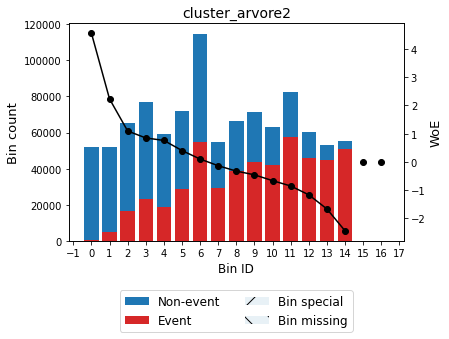

In [66]:
binning_process = BinningProcess(variable_names=list(['cluster_arvore2']))
binning_process.fit(df[['cluster_arvore2']], df['flag_mgm'])

optb = binning_process.get_binned_variable(name='cluster_arvore2')
optb.binning_table.plot()

In [67]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[CEAC, BDCA, DAAD, BDAC, BDAB, BCDA, BCCA, DBA...",52030,0.052030,51492,538,0.010340,4.561323,0.464835,0.033070
1,"[BDAA, AEAA, EFBA, ABAA, CDCA, CEBA, CDDA, CDB...",52099,0.052099,47050,5049,0.096912,2.232021,0.187494,0.019532
2,"[AEAB, EDBA, CACA, GEAC, FDAB, GFDA, GFCA, GFB...",65146,0.065146,48836,16310,0.250361,1.096689,0.071342,0.008496
3,"[FGCC, HFDB, FGBC, DBDA, FDDC, AFCA, GGBB, DBA...",76991,0.076991,53941,23050,0.299386,0.850225,0.052529,0.006375
4,"[GEBB, AFDA, FDBA, ADBA, FCAA, AEDA, AECA, GEC...",59357,0.059357,40475,18882,0.318109,0.762475,0.032928,0.004019
5,"[GEDA, DBCA, HFBB, ECCA, GGAD, AGAD, JDAB, EBA...",71926,0.071926,43136,28790,0.400273,0.40433,0.011601,0.001440
6,"[AFDB, GCAB, EACB, GFAB, IEAB, GDBD, IGCB, GDB...",114866,0.114866,60380,54486,0.474344,0.102714,0.001211,0.000151
7,"[ADBB, JEBC, JEBB, IEBD, FBBD, GGBC, GDBC, HED...",54646,0.054646,25508,29138,0.533214,-0.133051,0.000966,0.000121
8,"[HCAC, KGCA, KFCC, IDAA, JDAA, IGDC, EAAC, FBD...",66507,0.066507,27906,38601,0.580405,-0.324436,0.006940,0.000864
9,"[EAAD, FCBD, FACB, GFDD, JGDB, HDBC, IEDB, AEB...",71494,0.071494,27746,43748,0.611911,-0.455354,0.014573,0.001806


In [68]:
df['cluster_arvore_vl'] = binning_process.transform(df, metric="event_rate")

In [73]:
len(df.query('cluster_arvore_vl >= 0.90').cluster_arvore2.unique())

132

In [71]:
df.query('cluster_arvore_vl >= 0.90').cluster_arvore2.value_counts()

JDDD    12009
JCDD     6129
JDCD     4976
JDDC     4887
KDDD     4077
        ...  
CDAD        1
KDAB        1
DEDD        1
KBAB        1
EFCC        1
Name: cluster_arvore2, Length: 132, dtype: int64

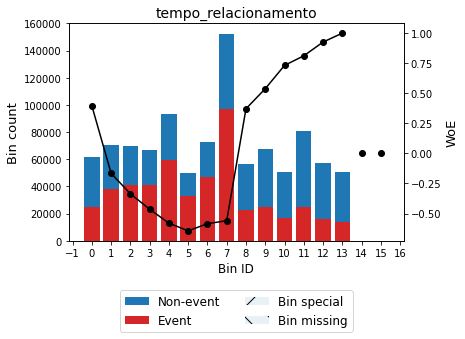

In [74]:
binning_process = BinningProcess(variable_names=list(['tempo_relacionamento']))
binning_process.fit(df[['tempo_relacionamento']], df['flag_mgm'])

optb = binning_process.get_binned_variable(name='tempo_relacionamento')
optb.binning_table.plot()

In [75]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 34.50)",61895,0.061895,36974,24921,0.402633,0.394504,0.009510,0.001181
1,"[34.50, 73.50)",70467,0.070467,32308,38159,0.541516,-0.166447,0.001948,0.000243
2,"[73.50, 112.50)",69961,0.069961,29167,40794,0.583096,-0.335497,0.007802,0.000971
3,"[112.50, 153.50)",66815,0.066815,25789,41026,0.614024,-0.464258,0.014148,0.001753
4,"[153.50, 241.50)",93235,0.093235,33466,59769,0.641058,-0.579957,0.030509,0.003761
5,"[241.50, 310.50)",50070,0.050070,17247,32823,0.655542,-0.643491,0.020046,0.002463
6,"[310.50, 407.50)",72531,0.072531,25966,46565,0.642001,-0.584061,0.024062,0.002966
7,"[407.50, 666.50)",152455,0.152455,55451,97004,0.636280,-0.559252,0.046477,0.005735
8,"[666.50, 821.50)",56168,0.056168,33233,22935,0.408329,0.370879,0.007639,0.000949
9,"[821.50, 1044.50)",67792,0.067792,42789,25003,0.368819,0.537285,0.019112,0.002361


In [76]:
import shap

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[predictors], df['flag_mgm'], test_size = 0.2)
# Prepares a default instance of the random forest regressor
model = RandomForestClassifier()
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestClassifier()

In [80]:
df_sample = df.sample(10000)

In [83]:
explainer = shap.Explainer(model.predict, df_sample[predictors])

In [84]:
shap_values = explainer(df_sample[predictors])

Permutation explainer: 10001it [4:04:02,  1.47s/it]                            


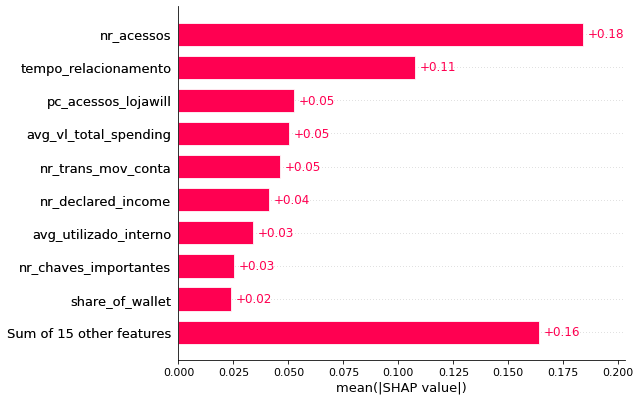

In [85]:
shap.plots.bar(shap_values)

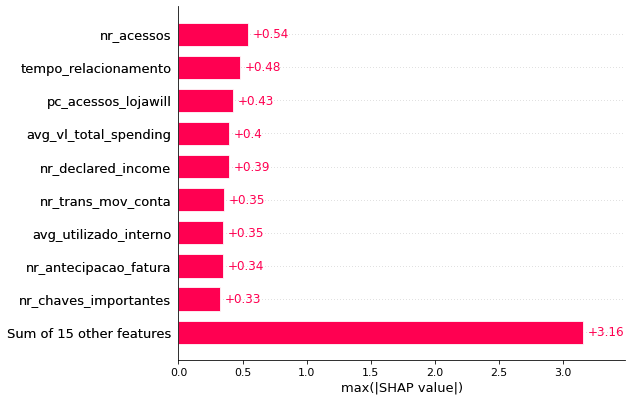

In [93]:
shap.plots.bar(shap_values.abs.max(0))

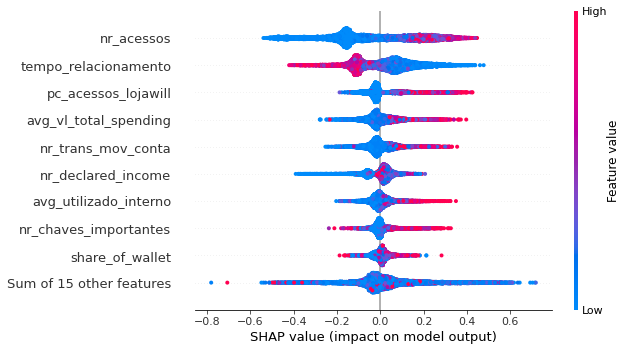

In [86]:
shap.plots.beeswarm(shap_values)

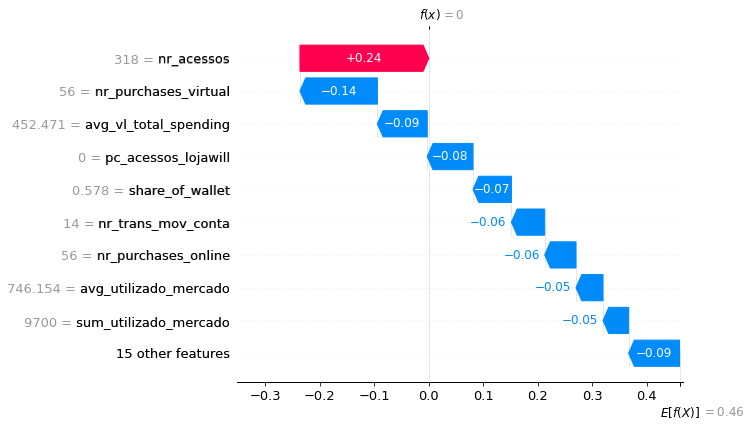

In [87]:
shap.plots.waterfall(shap_values[0])

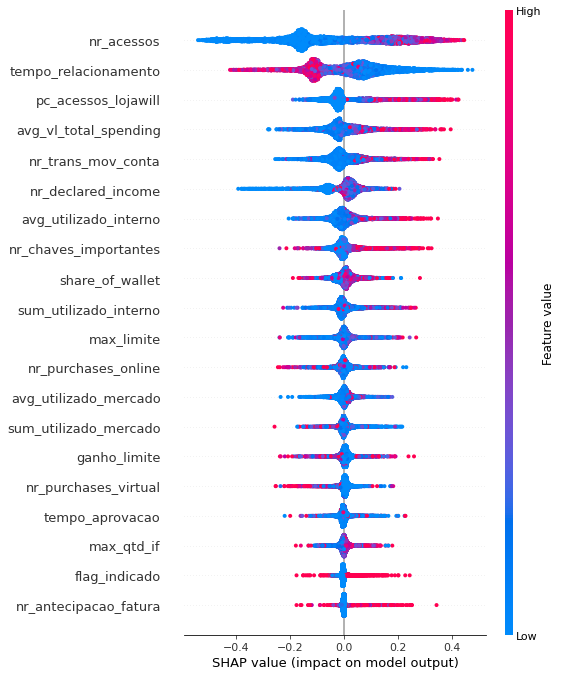

In [89]:
shap.summary_plot(shap_values, df_sample[predictors])

In [92]:
shap.initjs()
shap.plots.force(shap_values[0])

## Criando faixas mais compactas

In [108]:
df['fx_nr_acessos']  = np.where(df.nr_acessos <=  df.nr_acessos.quantile(0.25), 'A',
                                  np.where(df.nr_acessos <=  df.nr_acessos.quantile(0.75), 'B', 'C'))

df['fx_nr_acessos'].value_counts(normalize=True)

B    0.433871
A    0.317375
C    0.248754
Name: fx_nr_acessos, dtype: float64

In [109]:
df['fx_tempo_relacionamento'] = np.where(df.tempo_relacionamento_meses <=  5, 'A',
                                  np.where(df.tempo_relacionamento_meses <=  20, 'B', 'C'))

df['fx_tempo_relacionamento'].value_counts(normalize=True)

C    0.398724
B    0.335864
A    0.265412
Name: fx_tempo_relacionamento, dtype: float64

In [110]:
df['fx_loja_will'] = np.where(df.pc_acessos_lojawill > 0, 'A', 'B')
df['fx_loja_will'].value_counts(normalize=True)

B    0.746502
A    0.253498
Name: fx_loja_will, dtype: float64

In [112]:
df['fx_spending_ou_conta'] = np.where((df.avg_vl_total_spending <= df.avg_vl_total_spending.quantile(0.50)) & (df.nr_trans_mov_conta <= df.nr_trans_mov_conta.quantile(0.50)), 'A',
                             np.where((df.avg_vl_total_spending > df.avg_vl_total_spending.quantile(0.50)) & (df.nr_trans_mov_conta <= df.nr_trans_mov_conta.quantile(0.50)), 'B',
                             np.where((df.avg_vl_total_spending <= df.avg_vl_total_spending.quantile(0.50)) & (df.nr_trans_mov_conta > df.nr_trans_mov_conta.quantile(0.50)), 'C',                  
                             np.where((df.avg_vl_total_spending >= df.avg_vl_total_spending.quantile(0.50)) & (df.nr_trans_mov_conta >= df.nr_trans_mov_conta.quantile(0.50)), 'D',
                             np.where(df.avg_vl_total_spending >=  df.avg_vl_total_spending.quantile(0.75), 'D', 'Ni')))))

df['fx_spending_ou_conta'].value_counts(normalize=True)

A    0.421413
B    0.238578
D    0.208355
C    0.131654
Name: fx_spending_ou_conta, dtype: float64

In [113]:
df['cluster_regra'] = df['fx_nr_acessos'] + df['fx_tempo_relacionamento'] + df['fx_loja_will'] + df['fx_spending_ou_conta']

In [114]:
df['cluster_regra'].value_counts()

ACBA    133084
BABA     92056
ACBB     70983
ACBD     70077
BBBA     69914
BABB     52870
CBAD     41087
ACBC     38634
BAAA     35596
CBBD     34725
BAAB     26364
BBAA     25873
BBBB     23651
CBAC     23367
BCBA     21859
CBBC     18354
CBBB     16685
CBBA     15191
CBAA     12677
BBBC     12621
CBAB     12620
CCBD     11347
CAAD     10077
BBAB      9714
BBAC      9691
CCBB      8723
BABD      8406
CCAD      8262
BAAD      7998
BAAC      7507
BABC      7178
BCBB      6859
CABD      5951
BBBD      5507
CCBC      5499
CCBA      5341
CCAC      4567
CCAB      3975
AABA      3730
BBAD      3382
CAAB      2971
CCAA      2689
CABB      2270
BCBC      2003
BCAA      1959
BCBD      1311
CAAC      1090
BCAB       824
ABBA       695
BCAC       541
CABC       537
CAAA       480
CABA       269
BCAD       187
ABBC        65
AABB        58
ABBD        34
ABBB        11
AABD         4
Name: cluster_regra, dtype: int64

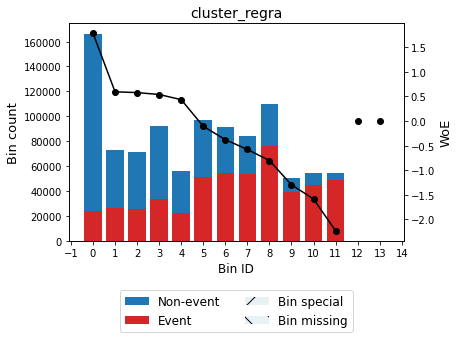

In [115]:
binning_process = BinningProcess(variable_names=list(['cluster_regra']))
binning_process.fit(df[['cluster_regra']], df['flag_mgm'])

optb = binning_process.get_binned_variable(name='cluster_regra')
optb.binning_table.plot()

In [116]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[ABBB, ABBC, ABBA, ABBD, AABA, BCBA, ACBA, AAB...",166395,0.166395,142537,23858,0.143382,1.787482,0.424273,0.046939
1,"[BCBC, BCBD, BBBA]",73228,0.073228,47196,26032,0.355492,0.594983,0.025184,0.003102
2,[ACBB],70983,0.070983,45493,25490,0.359100,0.579272,0.023174,0.002857
3,[BABA],92056,0.092056,58166,33890,0.368145,0.540181,0.026227,0.003239
4,"[ACBC, BCAB, BCAA, CCBB, BCAD, CCBA]",55668,0.055668,33802,21866,0.392793,0.435587,0.010398,0.001290
5,"[AABD, BBBC, BBBB, BCAC, BABB, BABC]",96865,0.096865,45857,51008,0.526589,-0.106455,0.001097,0.000137
6,"[CCBC, BAAA, CBBA, CCAB, BBAA, BBBD]",91641,0.091641,37270,54371,0.593304,-0.377642,0.012916,0.001605
7,"[CCAA, ACBD, CCBD]",84113,0.084113,30244,53869,0.640436,-0.577257,0.027275,0.003363
8,"[CBBC, BBAB, BABD, BAAB, BBAC, CABC, BAAC, CBA...",110204,0.110204,34111,76093,0.690474,-0.802336,0.067367,0.008202
9,"[CCAC, BBAD, BAAD, CABB, CBAC, CAAA, CCAD]",50326,0.050326,10812,39514,0.785161,-1.295998,0.074395,0.008699


In [117]:
df['cluster_arvore_vl'] = binning_process.transform(df, metric="event_rate")

In [119]:
df[['cluster_arvore_vl', 'cluster_regra']].groupby('cluster_regra').mean().to_csv('grupos_rate.csv')

In [124]:
df['target_regra'] = np.where(df.cluster_arvore_vl >= 0.70, 1, 0)

In [125]:
print(classification_report(df['flag_mgm'], df['target_regra']))

              precision    recall  f1-score   support

           0       0.56      0.95      0.71    500000
           1       0.84      0.27      0.41    500000

    accuracy                           0.61   1000000
   macro avg       0.70      0.61      0.56   1000000
weighted avg       0.70      0.61      0.56   1000000

